In [33]:
import os
import json
import torch

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, roc_auc_score
from datasets import Dataset, DatasetDict

# Configuración de dispositivo (GPU o CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## 1. Cargar y Preparar el Dataset

In [16]:
# Cargar textos humanos
human_texts = []
with open("data/human.jsonl", "r", encoding="utf-8") as file:
    for line in file:
        data = json.loads(line)
        human_texts.append({"text": data["text"], "label": 0})  # Etiqueta 0 para texto humano

# Cargar textos generados por máquina
machine_texts = []
machine_folder = "data/machine"
for filename in os.listdir(machine_folder):
    if filename.endswith(".jsonl"):
        with open(os.path.join(machine_folder, filename), "r", encoding="utf-8") as file:
            for line in file:
                data = json.loads(line)
                machine_texts.append({"text": data["text"], "label": 1})  # Etiqueta 1 para texto generado por máquina

# Combinar y dividir en conjunto de entrenamiento y validación
all_texts = human_texts + machine_texts

# Crear dataset de Hugging Face
dataset = Dataset.from_list(all_texts)
train_test_split = dataset.train_test_split(test_size=0.2)
dataset = DatasetDict({
    'train': train_test_split['train'],
    'validation': train_test_split['test']
})

In [17]:
dataset["train"], dataset["validation"]

(Dataset({
     features: ['text', 'label'],
     num_rows: 12174
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 3044
 }))

C:\Users\aleja\AppData\Local\Temp\ipykernel_18040\832259546.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="label", palette="viridis")


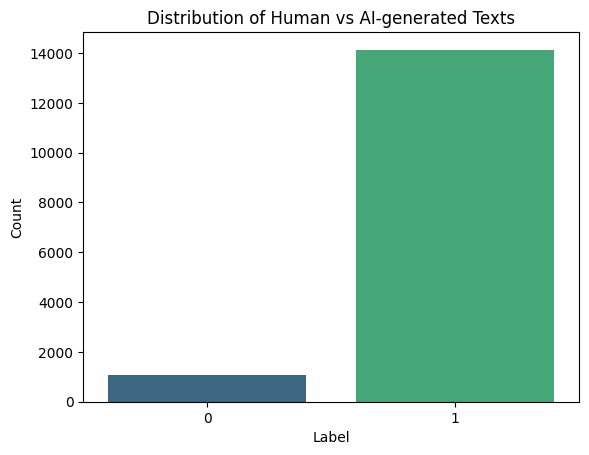

C:\Users\aleja\AppData\Local\Temp\ipykernel_18040\832259546.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="label", y="text_length", palette="viridis")


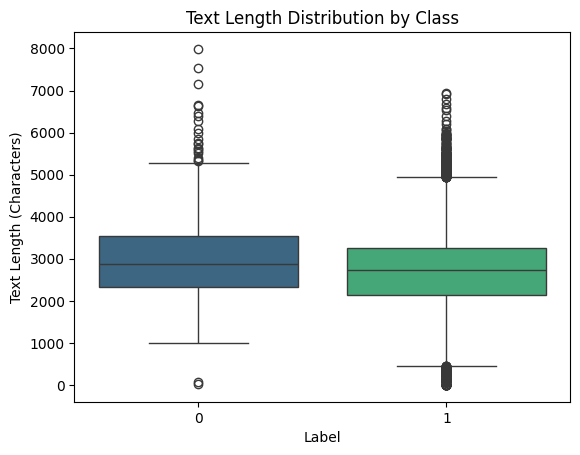

Ejemplos de textos humanos:
['\'Rust\' assistant director who handed Alec Baldwin prop gun subpoenaed after declining investigation interview\n\nSANTA FE, N.M. — The assistant director who handed Alec Baldwin a prop gun that killed a cinematographer on a New Mexico film set must make himself available for an interview with state workplace safety regulators, a judge has decided.\n\nDistrict Judge Bryan Biedscheid on Friday granted a request by the Occupational Health and Safety Bureau of the state Environment Department to issue a subpoena to Dave Halls, assistant director for the movie "Rust," local news outlets reported.\n\nCinematographer Halyna Hutchins was killed and director Joel Souza was wounded in the Oct. 21 shooting on the Bonanza Creek Ranch film set near Santa Fe.\n\nSafety officials tried twice since Nov. 2 to interview Halls for their investigation but he declined both times through his attorney and said he wouldn\'t agree to an interview until a criminal investigation in

In [18]:
df = pd.DataFrame(all_texts)

# 1. Visualizar la distribución de clases
sns.countplot(data=df, x="label", palette="viridis")
plt.title("Distribution of Human vs AI-generated Texts")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

# 2. Longitud promedio de textos en cada clase
df["text_length"] = df["text"].apply(len)
sns.boxplot(data=df, x="label", y="text_length", palette="viridis")
plt.title("Text Length Distribution by Class")
plt.xlabel("Label")
plt.ylabel("Text Length (Characters)")
plt.show()

# 3. Ejemplos de texto de cada clase
print("Ejemplos de textos humanos:")
human_samples = df[df["label"] == 0]["text"]
if len(human_samples) >= 3:
    print(human_samples.sample(3, random_state=42).values)
else:
    print("No hay suficientes ejemplos humanos para mostrar.")

# Ejemplos de textos generados por IA
print("\nEjemplos de textos generados por IA:")
ai_samples = df[df["label"] == 1]["text"]
if len(ai_samples) >= 3:
    print(ai_samples.sample(3, random_state=42).values)
else:
    print("No hay suficientes ejemplos de IA para mostrar.")


## 2. Tokenización y Preprocesamiento

In [19]:
# Cargar el tokenizador de RoBERTa
#model_name = "roberta-large"
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
max_length = 512  # Longitud máxima de tokens

# Función de tokenización
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, max_length=max_length)

# Tokenizar los datos
dataset = dataset.map(tokenize, batched=True)
dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/12174 [00:00<?, ? examples/s]

Map:   0%|          | 0/3044 [00:00<?, ? examples/s]

In [20]:
# Mostrar los primeros ejemplos del dataset tokenizado
print("Primeros 3 ejemplos del dataset tokenizado:")

for i in range(3):
    example = dataset["train"][i]
    input_ids = example["input_ids"]
    attention_mask = example["attention_mask"]
    label = example["label"]

    # Decodificar los input_ids de vuelta a texto (muestra de los primeros tokens)
    decoded_input = tokenizer.decode(input_ids, skip_special_tokens=True)
    
    print(f"\nEjemplo {i+1}:")
    #print(f"Texto original (decodificado): {decoded_input}")
    print(f"Input IDs: {input_ids[:10]}...")  # Mostrar solo los primeros 10 IDs para no saturar
    print(f"Attention Mask: {attention_mask[:10]}...")  # Solo primeros 10 elementos
    print(f"Etiqueta (Label): {label}")

Primeros 3 ejemplos del dataset tokenizado:

Ejemplo 1:
Input IDs: tensor([    0,   771,  9903,   352,  2265, 11667,    13,   901,  8699,    25])...
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])...
Etiqueta (Label): 1

Ejemplo 2:
Input IDs: tensor([    0, 31525,    12,   530, 28128, 31523,    13, 15767,  4414, 39465])...
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])...
Etiqueta (Label): 1

Ejemplo 3:
Input IDs: tensor([    0,   387, 44140,  5191,    18, 19150,   808,    12,  1646, 20527])...
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])...
Etiqueta (Label): 1


## 3. Configuración y Fine-Tuning del Modelo

In [ ]:
# Cargar el modelo desde el checkpoint (sin el estado del entrenador)
checkpoint_path = "./results/checkpoint-500"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint_path, num_labels=2).to(device)

# Definir métricas de evaluación
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# Definir los argumentos de entrenamiento (puedes ajustar los valores si lo necesitas)
training_args = TrainingArguments(
    output_dir="./results",  # Directorio donde se guardarán los resultados y checkpoints
    eval_strategy="epoch",
    logging_dir="./logs",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.01,
    resume_from_checkpoint=True,  # Permite reanudar el entrenamiento desde el último checkpoint
)

# Configurar el entrenador de Hugging Face
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    compute_metrics=compute_metrics
)

# Continuar el entrenamiento, pero sin el estado anterior
trainer.train()

c:\Users\aleja\Documents\github\NLP\.venv\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/761 [00:00<?, ?it/s]

{'loss': 0.0194, 'grad_norm': 0.00010775662667583674, 'learning_rate': 6.8593955321944815e-06, 'epoch': 0.33}


  0%|          | 0/381 [00:00<?, ?it/s]

{'eval_loss': 0.10442820191383362, 'eval_accuracy': 0.9868593955321945, 'eval_f1': 0.9929873772791024, 'eval_precision': 0.9864158829676071, 'eval_recall': 0.9996470172961525, 'eval_runtime': 88.3122, 'eval_samples_per_second': 34.469, 'eval_steps_per_second': 4.314, 'epoch': 0.5}
{'train_runtime': 1509.6971, 'train_samples_per_second': 4.032, 'train_steps_per_second': 0.504, 'train_loss': 0.01449841347066551, 'epoch': 0.5}


TrainOutput(global_step=761, training_loss=0.01449841347066551, metrics={'train_runtime': 1509.6971, 'train_samples_per_second': 4.032, 'train_steps_per_second': 0.504, 'total_flos': 1601820105031680.0, 'train_loss': 0.01449841347066551, 'epoch': 0.5})

## 4. Evaluación

In [37]:
# Evaluar el modelo en el conjunto de validación y mostrar métricas
predictions = trainer.predict(dataset["validation"])
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

  0%|          | 0/381 [00:00<?, ?it/s]

Classification Report:
              precision    recall  f1-score   support

       Human       0.99      0.82      0.90       211
AI-generated       0.99      1.00      0.99      2833

    accuracy                           0.99      3044
   macro avg       0.99      0.91      0.94      3044
weighted avg       0.99      0.99      0.99      3044

Confusion Matrix:


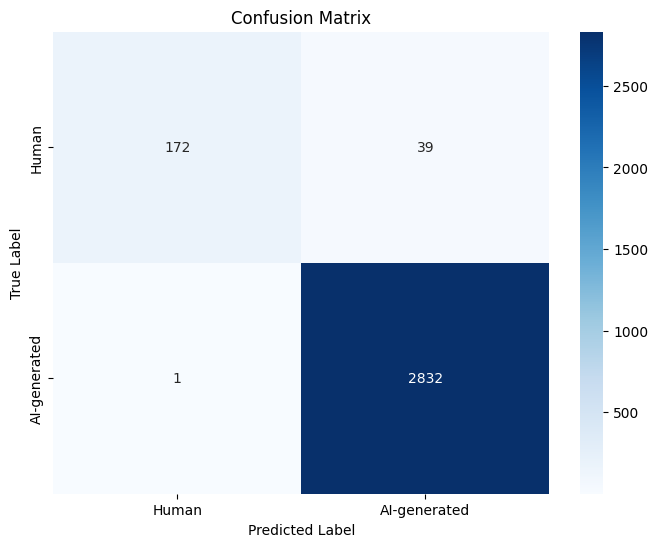

AUC: 0.9992


In [36]:
# Reporte de clasificación
print("Classification Report:")
print(classification_report(labels, preds, target_names=["Human", "AI-generated"]))

# Mostrar la matriz de confusión
print("Confusion Matrix:")
conf_matrix = confusion_matrix(labels, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Human", "AI-generated"], yticklabels=["Human", "AI-generated"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Si es un problema binario, se puede calcular el AUC (Area Under the Curve)
# Para ello, obtenemos las probabilidades en lugar de las predicciones de clase
probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=-1)
auc = roc_auc_score(labels, probs[:, 1].cpu())  # AUC para la clase "AI-generated" (posición 1)
print(f"AUC: {auc:.4f}")

In [40]:
def predict_text(text, model, tokenizer, device):
    # Tokenizar el texto de entrada
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    
    # Realizar la predicción
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Convertir las logits en probabilidades
    probs = torch.nn.functional.softmax(logits, dim=-1)
    prediction = torch.argmax(probs, dim=-1).item()
    
    # Mostrar la clase predicha
    predicted_class = "Human" if prediction == 0 else "AI-generated"
    predicted_prob = probs[0][prediction].item()

    return predicted_class, predicted_prob

# Probar la función con un texto ingresado
input_text = input("Escribe el texto para predecir: ")

predicted_class, predicted_prob = predict_text(input_text, model, tokenizer, device)
print(f"\nPredicción: {predicted_class}")
print(f"Probabilidad: {predicted_prob:.4f}")



Predicción: AI-generated
Probabilidad: 0.9970
